# Classical Portfolio Optimization

This notebook is used to generate a portfolio of 10 random stocks from the AlphaVantage API and then optimize the portfolio weights using Markowitz theory. The optimization analysis can be performed using 3 years of historical stock data (2014-2017). 

The returns of the portfolio with and without optimization over a 3 year test timeframe can then be calculated (2017-2020). These results will be used as the baseline in which the optimization performed through supervised and unsupervised learning will be compared.

In order to perform the optimization, the stock data must be obtained, the **expected returns** must be calculated, the **variance** of the stock data must be calculated and the **effecient frontier** must be found.


## Obtaining stock data



### Getting stock names
The stock names can be found by obtaining an array of all the stocks in the S&P 500 index, generating 10 random numbers and then using those numbers to choose 10 array items.

In [0]:
#Taken from Automating getting the S&P 500 list - Python Programming for Finance p.5
# https://pythonprogramming.net/sp500-company-list-python-programming-for-finance/

import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.strip("\n"))
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

save_sp500_tickers()
    

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'T',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ARNC',
 'ANET',
 'AJG',
 'AIZ',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CPRI',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA

Next 10 random numbers between 0 and 504 can be generated in order to pick 10 random stock tickers from the list

In [0]:
import random

#tickers = save_sp500_tickers()
#print(len(tickers)) # there are actually 505 stocks in the S&P 500, who knew!

def getRandomTickers(tickers):
  randIndex = []
  randTickers = []
  for i in range(0,10):
    randIndex.append(random.randint(0,504))
  for index in randIndex:
    randTickers.append(tickers[index])
  return randTickers


#print(getRandomTickers(tickers)) 


Now we can get the names of the tickers in the dataset. 

The data was extracted from the API using a NodeJS program which obtained daily price and volume data for each stock over a period of 20 years. Due to the failure to extract data for several stocks, the number of stock tickers is not exactly 505, but rather close to 500.

We first need to import the data from the csv into a pandas dataframe so that it can be further analyzed.

The data is stored in Google Drive and can be accessed via Colab after mounting to Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Now the csv can be imported into a dataframe


In [9]:
import pandas as pd
import time

#change directory to where the data is located 
!pwd

#use timer to get process times
start_time = time.time()

#read csv
data = pd.read_csv("SP_DAILY_2000-2020.csv")
#print("read data --- %s seconds ---" % (time.time() - start_time))

#preview first 5 lines
#start_time = time.time()
#print(data.head())
#print("get preview --- %s seconds ---" % (time.time() - start_time))

availableStocks = data['Symbol'].unique()
randomPortfolio = getRandomTickers(availableStocks)

print(randomPortfolio)

/content
['NFLX', 'APD', 'UNM', 'WBA', 'GE', 'MSI', 'NWL', 'AOS', 'PNC', 'STE']


In [11]:
stocksData = data[data['Symbol'].isin(randomPortfolio)]

print(stocksData)

        Symbol        Date    Open   Close    High       Low   Volume
56431      APD  2020-03-26  192.98  201.16  202.80  189.9800  1263120
56432      APD  2020-03-25  193.36  191.15  204.62  189.7200  2165256
56433      APD  2020-03-24  185.56  194.42  200.72  179.2700  2161648
56434      APD  2020-03-23  186.41  176.73  194.61  173.9124  2162822
56435      APD  2020-03-20  190.97  189.15  193.85  182.2875  2155623
...        ...         ...     ...     ...     ...       ...      ...
2151274    WBA  2000-03-30   26.06   25.13   26.06   24.8800  4160000
2151275    WBA  2000-03-29   26.69   26.00   27.50   25.9400  3251000
2151276    WBA  2000-03-28   26.38   26.63   27.19   26.2500  2953600
2151277    WBA  2000-03-27   26.50   26.44   26.56   25.7500  5142700
2151278    WBA  2000-03-24   27.00   28.00   28.44   26.8100  2561700

[49789 rows x 7 columns]


In [14]:
stocksData.loc[:,['DateTime']] = pd.to_datetime(stocksData.apply(lambda row: row['Date'], axis=1))

print(stocksData)

        Symbol        Date    Open  ...       Low   Volume   DateTime
56431      APD  2020-03-26  192.98  ...  189.9800  1263120 2020-03-26
56432      APD  2020-03-25  193.36  ...  189.7200  2165256 2020-03-25
56433      APD  2020-03-24  185.56  ...  179.2700  2161648 2020-03-24
56434      APD  2020-03-23  186.41  ...  173.9124  2162822 2020-03-23
56435      APD  2020-03-20  190.97  ...  182.2875  2155623 2020-03-20
...        ...         ...     ...  ...       ...      ...        ...
2151274    WBA  2000-03-30   26.06  ...   24.8800  4160000 2000-03-30
2151275    WBA  2000-03-29   26.69  ...   25.9400  3251000 2000-03-29
2151276    WBA  2000-03-28   26.38  ...   26.2500  2953600 2000-03-28
2151277    WBA  2000-03-27   26.50  ...   25.7500  5142700 2000-03-27
2151278    WBA  2000-03-24   27.00  ...   26.8100  2561700 2000-03-24

[49789 rows x 8 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [15]:
trainData = stocksData[(stocksData['DateTime'] > '2010-01-01') & (stocksData['DateTime'] < '2015-01-01')]

print(trainData)

        Symbol        Date    Open  ...      Low    Volume   DateTime
57748      APD  2014-12-31  145.68  ...  144.115   1037281 2014-12-31
57749      APD  2014-12-30  146.93  ...  146.180    649601 2014-12-30
57750      APD  2014-12-29  148.72  ...  147.760    532909 2014-12-29
57751      APD  2014-12-26  148.72  ...  148.040    323247 2014-12-26
57752      APD  2014-12-24  148.58  ...  148.050    272320 2014-12-24
...        ...         ...     ...  ...      ...       ...        ...
2148816    WBA  2010-01-08   36.92  ...   36.650   6139800 2010-01-08
2148817    WBA  2010-01-07   36.69  ...   36.470   5040700 2010-01-07
2148818    WBA  2010-01-06   36.16  ...   35.920   8945400 2010-01-06
2148819    WBA  2010-01-05   37.10  ...   36.620  10843200 2010-01-05
2148820    WBA  2010-01-04   37.01  ...   36.640   8171000 2010-01-04

[12580 rows x 8 columns]


In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

ValueError: ignored

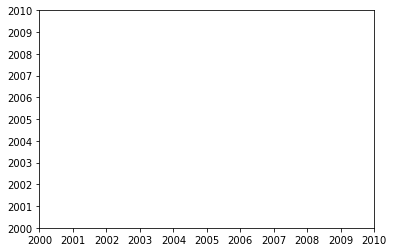

In [28]:
grouped_day = trainData.groupby(lambda x: trainData['DateTime'][x])
plt.figure()
x=grouped_day.size().index
y=[grouped_day['Close'], grouped_day['Close']]
plt.plot(x, grouped_day['Close'], 'r')
plt.show()